# Project 3: Image Recognition in Medical Treatment
## Diagnosing Skin Lesions using Machine Learning in Image Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *19.04.2021* / Last Modified: *08.04.2021*

---

This notebook contains the step-by-step data science process performed on the *ISIC 2017* public test data and official training data on medical image recognition. The goal of this project was to extract and automatically analyse features from medical images of skin lesions in order to predict whether or not the person has ** using machine learning and image processing.

The initial data (containing the medical images, masked images and information on features and disease) was given for 150 medical images (equivalent to the public test data of the *ISIC 2017* challenge) by the project manager *Veronika *.
To develop more accurate models, we extended the initially given data by the official training data that could be obtained from the official [ISIC 2017 Website](https://challenge.isic-archive.com/data)

## Introduction
---
The amount of medical imaging - just as data in any other field - has increased tremendously within the last decade, making it more and more difficult to manually inspect medical images for diagnosis purposes.

Furthermore, people have proven to be hesitant of visiting doctors because of seemingly 'light' issues, which did not seem to be important enough to occupy a doctor's time. With skin diseases being especially effective in treatment if detected early, this is fatal. 
An easy-to-use app that implements automated detection of skin diseases from the sofa, would address this issue - ultimately saving lives.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python Libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [1]:
%%capture
# uncomment lines with uninstalled packages

!pip install scikit-image
#!pip install scikit-learn
#!pip install pillow
#!pip install itertools

In [2]:
# python standard libraries
import json                                            # data transfer to json format
import os                                              # automates saving of export files (figures, summaries, ...)
import random                                          # randomness in coloring of plots
import re                                              # used for checking dateformat in data cleaning
import math                                            # mathematical computations
import requests                                        # requesting from website 
import zipfile                                         # Used to extract zip files

# external libraries
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import numpy as np                                     # used for numerical calculations and fast array manipulations
import matplotlib.pyplot as plt                        # visualisation of data
import seaborn as sns
from PIL import Image                                  # fork from PIL (python image library), deals with images in python

# specific functions
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # split data into train and test
from sklearn.preprocessing import StandardScaler # normalise features
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbour classifier
from sklearn.svm import SVC # support vector machine classifier
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.feature_selection import mutual_info_classif, SelectKBest # Univariate feature selection with mutual information for feature scoring

Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [3]:
#from project3.processing import ...
#from project3.save import ...
#from project3.features import ...
#from fyp2021p03g09_functions import *

**Remark**: All function used in this project are well documented in their *docstring*. To display the docstring and get an short summary of the function and the specifications of the input argument (including data tupe and small explanation) as well as their return value, type `?<function_name>` in Juptyer.

In [4]:
# global parameters for running the notebooks
DOWNLOAD_EXTERNAL_IMAGES = False
PREPROCESS_IMAGES = False
COMPUTE_FEATURES = True

## Downloading Additional Data
---
*some description*

In [5]:
if DOWNLOAD_EXTERNAL_IMAGES == True:
    # load in diagnosis, images and masks
    for i, url in enumerate(URL.values()):
        r = requests.get(url, allow_redirects=True) # request object
        if i == 1: open(PATH['data']['external'] + 'diagnosis.csv', 'wb').write(r.content)
        elif i == 2: open(PATH['data']['external'] + 'masks.zip', 'wb').write(r.content)
        elif i == 3: open(PATH['data']['external'] + 'images.zip', 'wb').write(r.content)

    # unzip images and masks
    for i, key in enumerate(URL.keys()[1:]):
        with zipfile.ZipFile(PATH['data']['external'] + key + '.zip','r') as zip_ref:
            zip_ref.extractall("../data/external")

    # delete zips

## Constants
---
To enhance the readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [6]:
ternal_w_URL = {}
URL['diagnosis'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
URL['masks'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip'
URL['images'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip'

PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"
PATH['data']['external'] = "../data/external/"

PATH['images'] = 'images/'
PATH['masks'] = 'masks/'
PATH['filtered_images'] = 'filtered_images/'
PATH['dummy_images']= 'dummy_images/'

PATH['reports'] = "../reports/"

# filename lookup dictionary storing the most relevant filenames
FILENAME = {}

# store filename of datasets involved
FILENAME['diagnosis'] = 'diagnosis.csv'
FILENAME['features'] = 'features.csv' 

# store filenames of different files in the project for easy iteration
FILENAME['rawrimages'] = FILENAME['masks'] = []x
for x in ['raw', 'external']:
    FILENAME['images'].append([image[:-4] for image in os.listdir(PATH['data'][x] + PATH['images']) if not re.match('.*super.*', image)])
    FILENAME['masks'] = [mask[:-4] for mask in os.listdir(PATH['data']['raw'] + PATH['masks'])]
FILENAME['images'] = sorted(FILENAME['images'])
FILENAME['masks'] = sorted(FILENAME['masks'])


FILENAME['dummy_images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['external'] + PATH['dummy_images'])])

# defining three dictionaries to store data. each dictionary will reference several pandas dataframes
DATA = {}

NAMES = {}
NAMES['datasets'] = ['diagnosis', 'features']
NAMES['images'] = ['images', 'masks']

SyntaxError: invalid syntax (<ipython-input-6-158d2b6f5399>, line 27)

**TASK 0**
# Image Preprocessing
---
In this section we preprocess our image to make it nicer to deal with them in the later part of the project.

1. Crop Images and Masks to be bound by lesion
2. Make Width and Length an even number to be able to crop evenly
3. Maybe save filtered image with color

In [ ]:
# helper function to make width and lengths even
def make_even(img):
    if img.size[0] % 2 != 0: #  making number of cols even
        img = np.array(img)
        mid = int(img.shape[1] / 2)
        img = np.delete(img, mid, axis=1)
        img = Image.fromarray(img)

    if img.size[1] % 2 != 0: # making number of rows even
        img = np.array(img)
        mid = int(img.shape[0] / 2)
        img = np.delete(img, mid, axis=0)
        img = Image.fromarray(img)
    
    return img

In [ ]:
# preprocessing (170 seconds to run)
if PREPROCESS_IMAGES == True:
    try: 
        os.makedirs(PATH['data']['processed'] + PATH['images'])
        os.makedirs(PATH['data']['processed'] + PATH['masks'])
        os.makedirs(PATH['data']['processed'] + PATH['filtered_images'])
    except: print('Directories already exist.')

    for i in range(len(FILENAME['images'])):
        # get image names
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        img = Image.open(PATH['data']['raw'] + PATH['images'] + img_name)
        mask = Image.open(PATH['data']['raw'] + PATH['masks'] + mask_name)

        # crop to only store lesion
        cropped_img = img.crop(mask.getbbox())
        cropped_mask = mask.crop(mask.getbbox())

        # make width and length even (two cases)
        cropped_img = make_even(cropped_img)
        cropped_mask = make_even(cropped_mask)

        # create filtered with color
        dummy = Image.new("RGB", cropped_img.size, 0)
        filtered_img = Image.composite(cropped_img, dummy, cropped_mask)
        
        # save to '../data/processed' in correct subfolder
        cropped_img.save(PATH['data']['processed'] + PATH['images'] + img_name)
        cropped_mask.save(PATH['data']['processed'] + PATH['masks'] + mask_name)
        filtered_img.save(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        

        
    print('Preprocessing Done')

Directories already exist.
Preprocessing Done


*TASK 0.5*
# Data Exploration

---


## Loading in Data

---

The task involves different sources of data, namely:

> **Images**: 150 Medical Images of Skin Lesions

> **Masks**: 150 Binary Masks corresponding to each Image that masks the region of the Skin Lesion

> **Diagnosis**: Dataset storing whether or not the lesion was either *melanoma* or *seborrheic_keratosis* through binary values

> **Features**: Dataset storing the area and perimeter of the skin lesion for each image

We conveniently load in the csv datasets into individual `Pandas DataFrames` using the built-in pandas method `pd.read_csv()`. We store those in our `DATA` dictionary in the corresponding keys.

All images and masks are stored as `Image` objects of the `PIL` (*Python Image Library*) for convenient handling of image processing functionality.

In [ ]:
# load in raw datasets 
DATA['diagnosis'] = pd.read_csv(PATH['data']['raw'] + FILENAME['diagnosis'])
DATA['features'] = pd.read_csv(PATH['data']['raw'] + FILENAME['features']) # not used in this project

In [ ]:
# load in raw images and masks
DATA['images'] = [Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg') for i in range(len(FILENAME['images']))]
DATA['masks'] = [Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png') for i in range(len(FILENAME['masks']))]

DATA['generator'] = ( (Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg'),
                           Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png')) 
                           for i in range(len(FILENAME['images'])) )

#DATA['generator'], DATA_RAW['generator_copy'] = itertools.tee(DATA_RAW['generator'])

## Inspection of Datasets

---

We can now have a look at our two datasets to get a first impression for what kind of data we are dealing with. We start by reporting the number of records and fields/ variables in each of the datasets by using the shape property of the `pd.DataFrame`. We then continue to have an actual look into the data. Similiar to the head command in terminal, we can use the method `head()` onto our DataFrames, which outputs an inline representation of the first five data records of the dataset.

**Shape**

In [ ]:
for dataset in NAMES['datasets']:
    print(f"{dataset.capitalize()}: {DATA[dataset].shape}")

Diagnosis: (150, 3)
Features: (150, 3)


**Diagnosis Dataset**

In [ ]:
DATA['diagnosis'].head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [ ]:
%%capture
# add diagnosis to df

# extract cols
mel = DATA['diagnosis']['melanoma']
ker = DATA['diagnosis']['seborrheic_keratosis']

# mask all cases
mel_mask = (mel == 1) & (ker == 0)
ker_mask = (mel == 0) & (ker == 1)
neither_mask = (mel == 0) & (ker == 0)
both_mask = (mel == 1) & (ker == 1)

DATA['diagnosis']['diagnosis'] = 0
for i in range(DATA['diagnosis'].shape[0]):
    if mel_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 2
    elif ker_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 1
    else: DATA['diagnosis']['diagnosis'].loc[i] = 0

0: 78
1: 42
2: 30


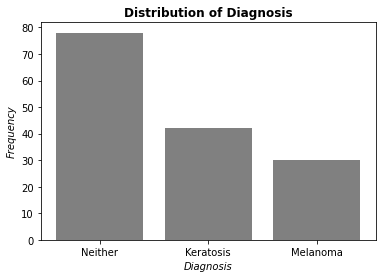

In [ ]:
# distribution of diagnosis

diagnosis, counts = np.unique(DATA['diagnosis']['diagnosis'], return_counts=True)

for x in range(len(diagnosis)):
    print(f"{diagnosis[x]}: {counts[x]}")

# plot
fig,ax = plt.subplots()
ax.bar(diagnosis, counts, color='gray')
# maybe add text with numeric count
ax.set_title('Distribution of Diagnosis', fontweight='bold'); ax.set_xlabel('Diagnosis', fontstyle='italic'); ax.set_ylabel('Frequency', fontstyle='italic');
ax.set_xticks(diagnosis); ax.set_xticklabels(['Neither', 'Keratosis', 'Melanoma']);

As we can see, the majority of observed skin lesions was healthy (78 / 150), one fifth of the skin lesions were diagnosed with melanoma and approximately one fourth was diagnosed with keratosis. 

The two diseases are - as expected - mutually exclusive, meaning that a single skin lesion cannot be diagnosed with multiple diseases.

**Features Dataset**

The features dataset so far only stores the area and perimeter for each given medical image. This dataset will be used to store all of our handcrafted features at a later point in the project.

In [ ]:
DATA['features'].head()

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0


## Inspection of Images
---
The main part of the project is to analyse medical images for a set of features. To do so, we can analyse both the original image and a binary mask provided in the raw data. In this section, we will look at examples of images and their corresponding mask to get a feel for the type of images we are dealing with and assess the quality of the masks.

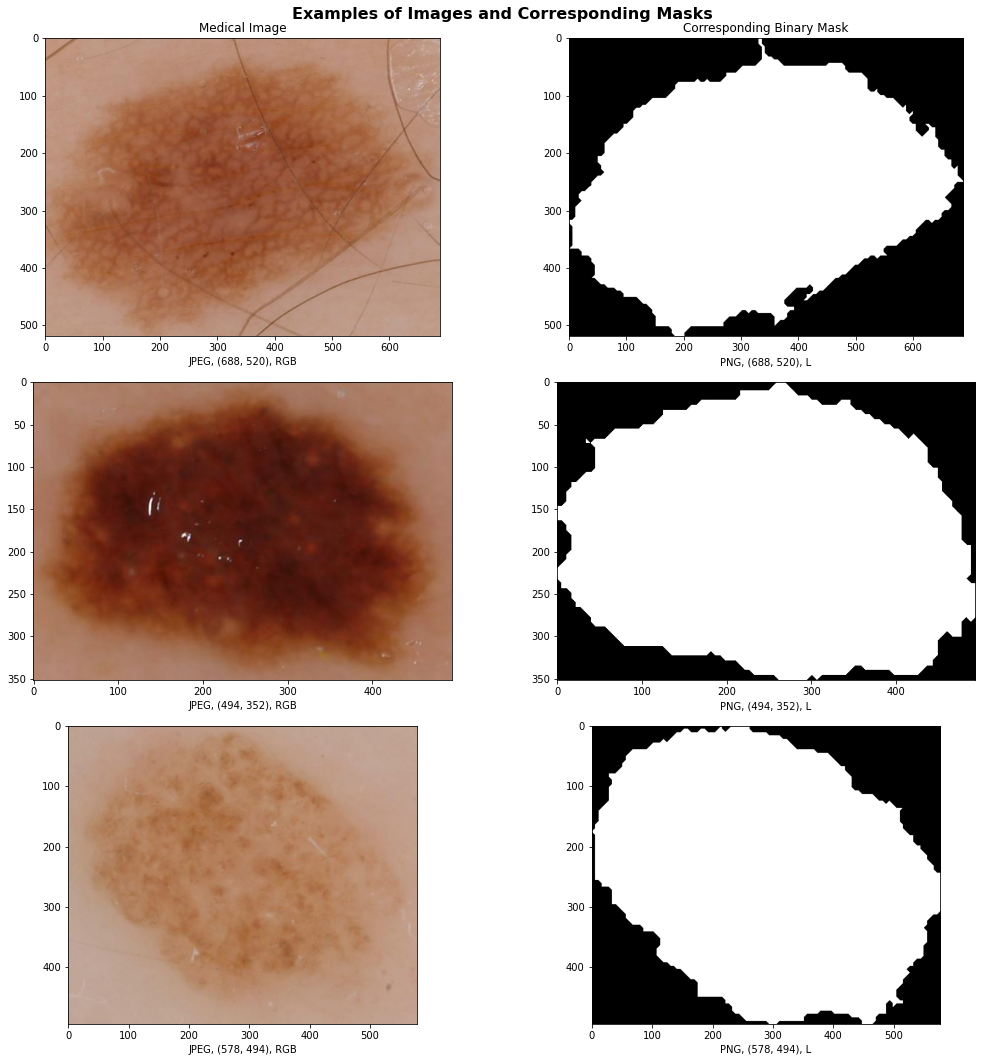

In [ ]:
# load test image using PIL
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.suptitle('Examples of Images and Corresponding Masks', fontsize=16, fontweight='bold')

for i in range(3):
    ex_img = Image.open('../data/processed/images/' + FILENAME['images'][i] + '.jpg')
    ex_img_mask = Image.open('../data/processed/masks/' + FILENAME['masks'][i] + '.png')

    ax[i][0].imshow(ex_img)
    ax[i][0].set_xlabel(f"{ex_img.format}, {ex_img.size}, {ex_img.mode}");
    ax[i][1].imshow(ex_img_mask, cmap='gray')
    ax[i][1].set_xlabel(f"{ex_img_mask.format}, {ex_img_mask.size}, {ex_img_mask.mode}");

ax[0][0].set_title('Medical Image');
ax[0][1].set_title('Corresponding Binary Mask');

plt.tight_layout()

*TASK 1*
# Extracting Features 

---

We need to find quantitative measures of how to best classify the skin abnormality *keratosis*. The following handcrafted features are assessed during this project:

> **Compactness**. A quantitative measure of the shape of the lesion. The smaller the value, the more compact the lesion is. A perfect circle has a compactness score of roughly *1.4*.

> **Average Luminance**. A quantitative measure of the averaged brightness of the lesion. The higher the value, the lighter the lesion, and vice versa. Values range from 0 (meaning 100% black) to 255 (meaning 100% white).

> **Luminance Variability**. A quantitative measure to determine the variation of luminance of the lesion. The higher the value, the more variation can be found on the lesion. 

> **Average Colour**. A quantitative measure of the averaged colour of the lesion. Values are in RGB format

> **Colour Variability**. A quantitative measure to determine the variation of color of the lesion. The higher the value, the more variation can be found on the lesion. output in the format of (rvariation,gvariation,bvariation),average variation

> **Asymmetry**. A quantitative measure to assess the symmetry of the lesion. Measured through relative number of non-overlapping pixels in different rotations. The higher the value, the less symmmetric the lesion is. A perfect circle, should score a 0 asymmetry score.

> **Border Smoothness**. (WE NEVER GOT THIS)

## Functions for Feature Extraction

In [ ]:
def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    mask = np.where(np.array(mask)==255, 1, 0)
    
    # compute area as number of white pixels 
    area = np.sum(mask)

    # compute perimeter by eroding 1 pixel from mask and then compute the difference between original and eroded mask
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)
    
    return area, perimeter

In [ ]:
# compactness
def get_compactness(mask):
    area, perimeter = measure_area_perimeter(mask)

    # return compactness formula
    return ( ( perimeter ** 2) / (4 * np.pi * area ) )

In [ ]:
# average luminance
def get_average_luminance(filtered_image): # image needs to be filtered for lesion
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    return round(np.mean(gray[gray > 0]))

In [ ]:
# luminance variability
def get_luminance_variability(filtered_image, measure='variance'):
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    if measure == 'variance': return round(np.var(gray[gray > 0]))
    elif measure == 'standard_deviation': return round(np.std(gray[gray > 0]))
    else: print('Cannot compute this `measure`. Try `variance` or `standard_deviation`')

In [ ]:
# average color
def get_average_color(filtered_image): # image needs to be filtered for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    return [round(np.mean(r[r > 0])),round(np.mean(g[g > 0])),round(np.mean(b[b > 0]))]

In [ ]:
# color variability
def get_color_variability(filtered_image, measure='variance'): # image needs to be filteredd for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    if measure == 'variance': rgb=(np.var(r[r > 0]),np.var(g[g > 0]),np.var(b[b > 0]))
    elif measure == 'standard_deviation': rgb=(np.std(r[r > 0]),np.std(g[g > 0]),np.std(b[b > 0]))
    else: return 
    return np.mean(rgb)

In [ ]:
def get_asymmetry(mask):
    return round(np.mean([asymmetry(mask), asymmetry(mask.rotate(90, expand=True))]),2)

In [ ]:
# helper for asymmetry
def asymmetry(mask):
    # calculate basic properties of image
    width, length = mask.size  # requires even number of pixels in both dimensions
    size = width * length

    if width%2!=0:
        print("Uneven Number of Pixels. Can't calculate asymmetry.")

    # cut in half and fold
    left = mask.crop((0,0,(width/2), length)) 
    right = mask.crop((width/2,0,width,length))
    right = right.transpose(Image.FLIP_LEFT_RIGHT)

    # get binary array of unequal positions (the closer the sum to 0, the better the symmetry)
    diff = np.where(np.array(left) != np.array(right), 1, 0)

    return np.sum(diff) / size # percentage of asymmetric pixels

In [ ]:
# border continuity
def get_border_shape():
    # cut the image in n parts from the midpoint of the lesion and measure the variance 
    # from drawing a straight line through thesee
    pass

## Evaluating Feature Extraction
---

Here we test the quality of the functions on sample lesions and dummy images.

###############   Dummy 1   ###############
Area / Perimeter      : 440464px / 2116px
Compactness           : 0.8089301905223416
Asymmetry             : 0.0px
Average Luminance     : 142
Luminance Variance    : 1017
Average Colors (RGB)  : [252, 92, 110]
Color Variability     : 1060.0278147020997

###############   Dummy 2   ###############
Area / Perimeter      : 193253px / 1806px
Compactness           : 1.3430722730474487
Asymmetry             : 0.05px
Average Luminance     : 94
Luminance Variance    : 68
Average Colors (RGB)  : [94, 94, 94]
Color Variability     : 67.8755454789472



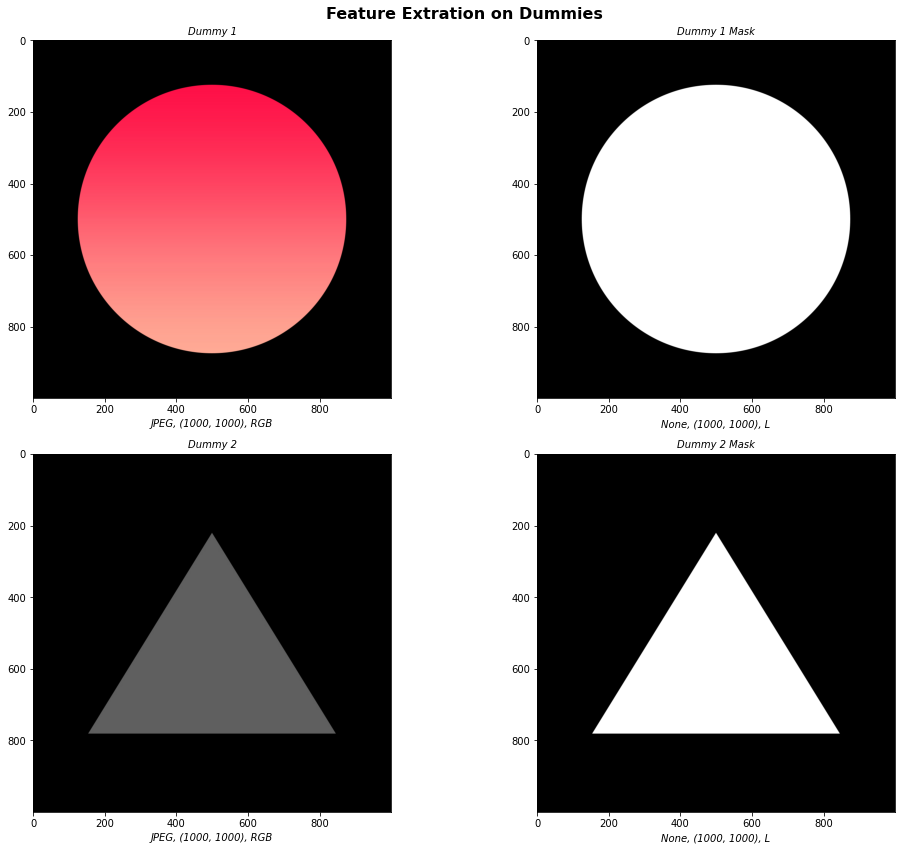

In [ ]:
dummies = ['dummy' + str(i+1) for i in range(2)]

# show dummy image and mask
fig, ax = plt.subplots(nrows=len(dummies), ncols=2, figsize=(16, 6 * len(dummies)))
fig.suptitle("Feature Extration on Dummies", fontsize=16, fontweight='bold')

for i, img_name in enumerate(dummies):
    # compute features
    img = Image.open('../data/external/' + img_name + '.jpg')
    img_mask = Image.open('../data/external/' + img_name + '_mask.png').convert('L')

    area, perimeter = measure_area_perimeter(img_mask)
    compactness = get_compactness(img_mask)
    asymmetry_score = get_asymmetry(img_mask)
    average_luminance = get_average_luminance(img)
    luminance_variance = get_luminance_variability(img)
    average_colors = get_average_color(img)
    color_variance = get_color_variability(img)

    # print out computed features
    print('#'*15 + f"   Dummy {i+1}   " + '#'*15)
    print(f"Area / Perimeter      : {area}px / {perimeter}px")
    print(f"Compactness           : {compactness}")
    print(f"Asymmetry             : {asymmetry_score}px")
    print(f"Average Luminance     : {average_luminance}")
    print(f"Luminance Variance    : {luminance_variance}")
    print(f"Average Colors (RGB)  : {average_colors}")
    print(f"Color Variability     : {color_variance}\n")

    ax[i][0].imshow(img);
    ax[i][1].imshow(img_mask, cmap='gray');
    ax[i][0].set_title(f'Dummy {i+1}', fontsize=10, fontstyle='italic')
    ax[i][1].set_title(f'Dummy {i+1} Mask', fontsize=10, fontstyle='italic')
    ax[i][0].set_xlabel(f'{img.format}, {img.size}, {img.mode}', fontstyle='italic');
    ax[i][1].set_xlabel(f'{img_mask.format}, {img_mask.size}, {img_mask.mode}', fontstyle='italic');
    plt.tight_layout()

## compactness
testing compactness function on dummy images

dummy1 should have a low compactness value

dummy2 should have a high compactness value

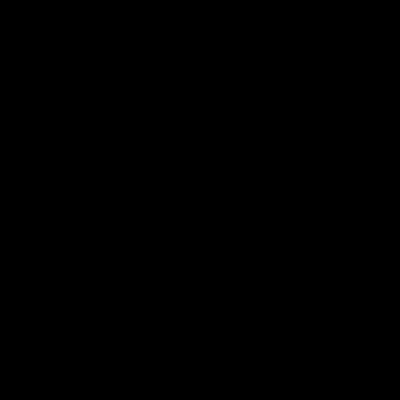

In [ ]:
# import dummy images
dummy1 = Image.open(PATH['data']['external'] + PATH['processed_dummy_images'] + 'specialised01.png')
dummy2 = Image.open(PATH['data']['external'] + PATH['processed_dummy_images'] + 'specialised02.png')
dummy1_mask = Image.open(PATH['data']['external'] + PATH['processed_dummy_images'] + 'specialised01_mask.png')
dummy2_mask = Image.open(PATH['data']['external'] + PATH['processed_dummy_images'] + 'specialised02_mask.png')

dummy1_mask
#print(get_compactness(dummy1_mask))

In [ ]:
# features to print:
# measure_area_perimeter()
# get_compactness()
# get_asymmetry()
# get_color_variability()
# get_average_color()
# get_average_luminance()
# get_luminance_variability()
dummies = [dummy1, dummy1_mask, dummy2, dummy2_mask]
feature_test_mask = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0001852_segmentation.png')
print(measure_area_perimeter(feature_test_mask))

for img in dummies:
    if img == dummy1:
        print("########## dummy1 ###########")

    if img == dummy2:
        print("########## dummy2 ###########")

# NEED TO FIX DUMMY IMAGE MASKS, IDK WTF IM DOING
    if img == dummy1_mask or img == dummy2_mask:
        print("area perim :", measure_area_perimeter(img))
        print("compactness:", get_compactness(img))
        print("asymmetry  :", get_asymmetry(img))
        continue

# NEED TO FIX INPUT FOR COLOR VARIABILITY AND AVERAGE COLOR
    if img == dummy1 or img == dummy2:
        # print("color vari :", get_color_variability(img))
        # print("avrg color :", get_average_color(img))
        print("avrg lumin :", get_average_luminance(img))
        print("lumin vari :", get_luminance_variability(img))

(130493, 1270)
########## dummy1 ###########
avrg lumin : 112
lumin vari : 1410
area perim : (0, 0)
compactness: nan
asymmetry  : 0.0
########## dummy2 ###########
avrg lumin : 126
lumin vari : 4125
area perim : (0, 0)
compactness: nan
asymmetry  : 0.0
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


## Compute Features
---

We have developed our functions to extract abstracted features from the medical images of the lesions and have proven them to work on dummy images, where we were able to validate assumed scores in each feature. We can therefore now compute the features for each image and append it to our main dataframe to store the data, that is later used to train our model. 

We first read in the measured features into a dictionary `feature_dict`, which we later concatenate horizontally with `features.csv` dataset. 

In [ ]:
features = ['compactness', 'average_luminance', 'luminance_variability', 'average_red', 'average_green', 'average_blue', 'color_variability', 'asymmetry']

feature_functions = {
    'compactness': get_compactness,
    'average_luminance': get_average_luminance,
    'luminance_variability': get_luminance_variability,
    'average_red': get_average_color,
    'average_green': get_average_color,
    'average_blue': get_average_color,
    'color_variability': get_color_variability,
    'asymmetry': get_asymmetry
}

In [ ]:
# compute all features (execution time: 60s)
if COMPUTE_FEATURES == True:
    feature_dict = {feature: [] for feature in features}

    for i in range(len(FILENAME['images'])):
        name = FILENAME['images'][i]
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        filtered_img = Image.open(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        mask = Image.open(PATH['data']['processed'] + PATH['masks'] + mask_name)

        # measure features and append to feature_dict
        for feature in features:
            if feature in ['compactness', 'asymmetry']:
                feature_dict[feature].append(feature_functions[feature](mask))
            elif feature in ['average_luminance', 'luminance_variability', 'color_variability']:
                feature_dict[feature].append(feature_functions[feature](filtered_img))
            elif feature == 'average_red':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[0])
            elif feature == 'average_green':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[1])
            elif feature == 'average_blue':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[2])

### Build Main DataFrame
---
*add small description*

In [ ]:
# append extracted features and diagnosis to features.csv
if DATA['features'].shape[1] <= 3:
    DATA['features'] = pd.concat([DATA['features'], pd.DataFrame(feature_dict)], axis=1) # concatenating handcrafted features
    DATA['features'] = pd.concat([DATA['features'], DATA['diagnosis'][['melanoma', 'seborrheic_keratosis', 'diagnosis']]], axis=1) # concatenating diagnosis

In [ ]:
DATA['features']

,id,area,perimeter,compactness,average_luminance,luminance_variability,color_variability,asymmetry,average_red,average_blue,average_green,melanoma,seborrheic_keratosis,diagnosis
0,ISIC_0001769,216160.0,2013.0,1.460703,108,977,780.760582,0.10,155,66,96,0.0,0.0,0
1,ISIC_0001852,130493.0,1372.0,0.983582,66,1164,1065.616653,0.06,111,32,53,0.0,0.0,0
2,ISIC_0001871,205116.0,1720.0,0.999238,138,1094,825.166031,0.13,175,100,131,0.0,0.0,0
3,ISIC_0003462,161705.0,1344.0,0.743362,123,1207,1157.012146,0.03,160,86,114,0.0,0.0,0
4,ISIC_0003539,317040.0,2063.0,1.058382,110,1337,1194.831694,0.21,160,62,97,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,1.180344,101,452,507.443671,0.05,139,64,89,0.0,0.0,0
146,ISIC_0015445,12049938.0,19517.0,2.387259,108,1946,1921.062199,0.29,154,82,91,0.0,0.0,0
147,ISIC_0015483,8856478.0,13813.0,1.445050,114,1339,1307.218390,0.04,142,92,105,0.0,0.0,0
148,ISIC_0015496,8951522.0,13742.0,1.490771,117,3638,3661.626976,0.10,172,78,98,0.0,0.0,0


### Normalise Features
---
When training our ML model, it is important that each feature equally contributes into the process of classification. Since features are on very different scales (*ie. 0-255 for Luminance/ Color or #Pixels for Asymmetry*), we normalise them using sklearn's `StandardScaler()` to normalise all numeric columns in the DataFrame `features.csv` and save the normalised DataFrame into `DATA['scaled_features']`.

In [ ]:
scaler = StandardScaler().fit(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = scaler.transform(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = pd.DataFrame(DATA["scaled_features"], columns=list(DATA['features'])[1:]) # convert back to pd.DataFrame
DATA['scaled_features']

,area,perimeter,compactness,average_luminance,luminance_variability,color_variability,asymmetry,average_red,average_blue,average_green,melanoma,seborrheic_keratosis,diagnosis
0,-0.493031,-0.674136,0.583781,-0.321653,-0.103682,-0.233735,0.024820,0.019358,-0.694363,-0.343366,-0.5,-0.62361,-0.865277
1,-0.507605,-0.795608,-0.478044,-1.913495,0.204398,0.241546,-0.758982,-1.597886,-1.882703,-1.899734,-0.5,-0.62361,-0.865277
2,-0.494909,-0.729661,-0.443202,0.815377,0.089074,-0.159645,0.612672,0.754469,0.493977,0.923445,-0.5,-0.62361,-0.865277
3,-0.502295,-0.800914,-1.012648,0.246862,0.275240,0.394039,-1.346834,0.203136,0.004660,0.308137,-0.5,-0.62361,-0.865277
4,-0.475868,-0.664661,-0.311578,-0.245851,0.489413,0.457141,2.180277,0.203136,-0.834168,-0.307172,-0.5,-0.62361,-0.865277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.126062,1.554817,-0.040154,-0.586960,-0.968611,-0.689763,-0.954932,-0.568731,-0.764266,-0.596728,-0.5,-0.62361,-0.865277
146,1.520243,2.642952,2.645812,-0.321653,1.492730,1.668853,3.747881,-0.017398,-0.135145,-0.524339,-0.5,-0.62361,-0.865277
147,0.976942,1.562018,0.548945,-0.094247,0.492708,0.644657,-1.150883,-0.458464,0.214367,-0.017615,-0.5,-0.62361,-0.865277
148,0.993111,1.548563,0.650695,0.019456,4.280273,4.572976,0.024820,0.644202,-0.274949,-0.270977,-0.5,-0.62361,-0.865277


### Saving DataFrame
---
Save both `feature` dataframes into `csv` format into `../data/processed`.

In [ ]:
# save features and scaled features
DATA['features'].to_csv(PATH['data']['processed'] + 'features.csv')
DATA['scaled_features'].to_csv(PATH['data']['processed'] + 'scaled_features.csv')

*TASK 1.5*
# Evaluate Features for Classification
---

In this section, we are plotting the handcrafted features in order to see, whether any correaltions appear. Since we are trying to classify a binary label, namely whether a lesion is diseased with *melanoma* or not, we plot the distribution of each feature in the two classes *melanoma* and *no melanoma* to get a visual intuition of how good the specific feature might be able to distinguish between our target label. 
The more distinct the two distributions are, the better the feature will be at prediciting the tartget value.

### Visual Exploration

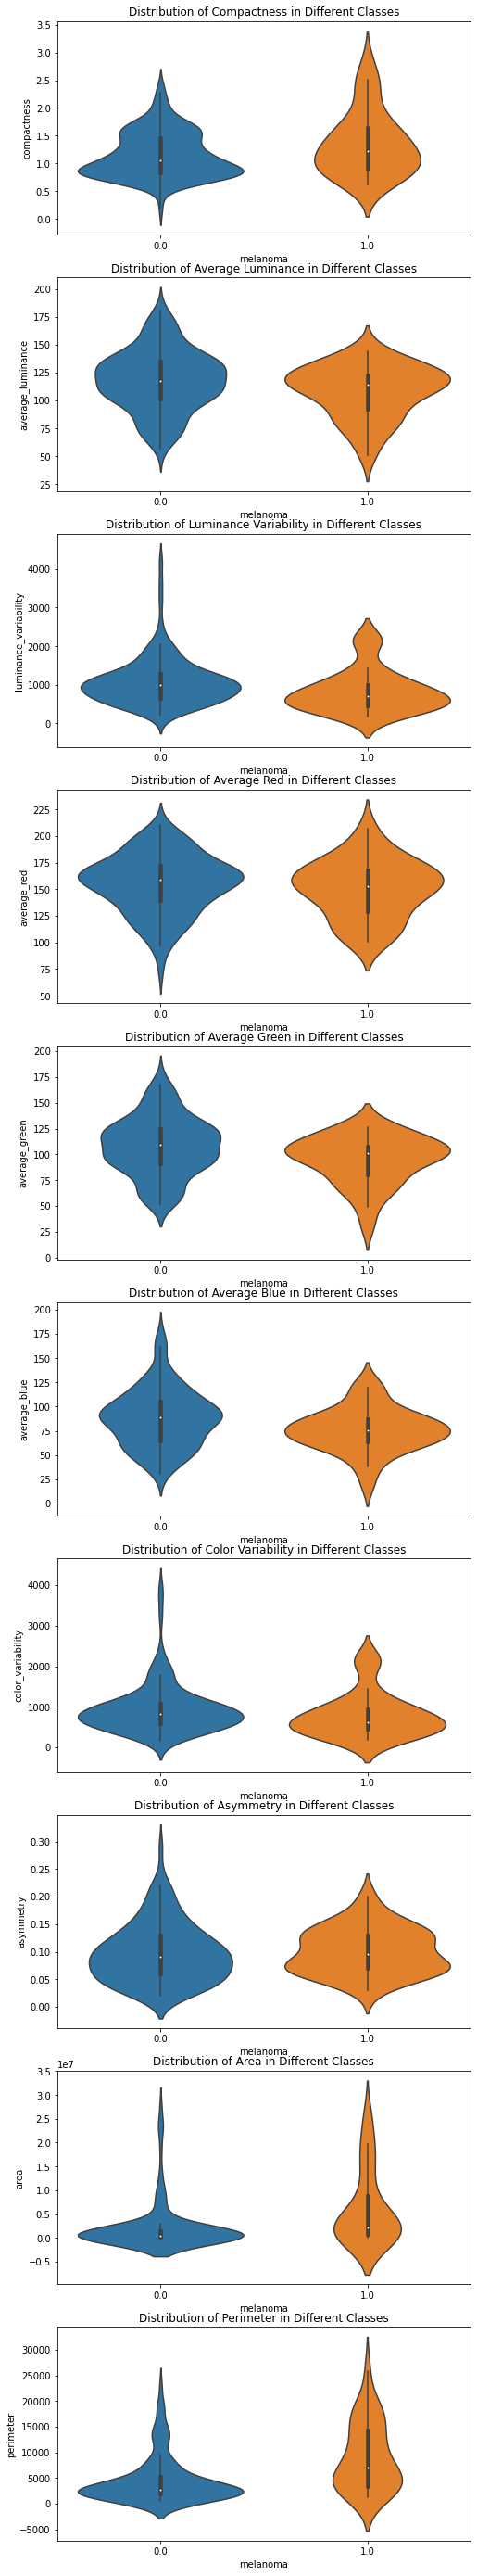

In [ ]:
fig, ax = plt.subplots(nrows=len(features) + 2, figsize=(8, 6 * len(features) + 2))

for i, feature in enumerate(features + ['area', 'perimeter']):
    sns.violinplot(x='melanoma', 
                   y=feature, 
                   data=DATA['features'],  
                   ax=ax[i]).set_title(f"Distribution of {feature.title().replace('_', ' ')} in Different Classes");

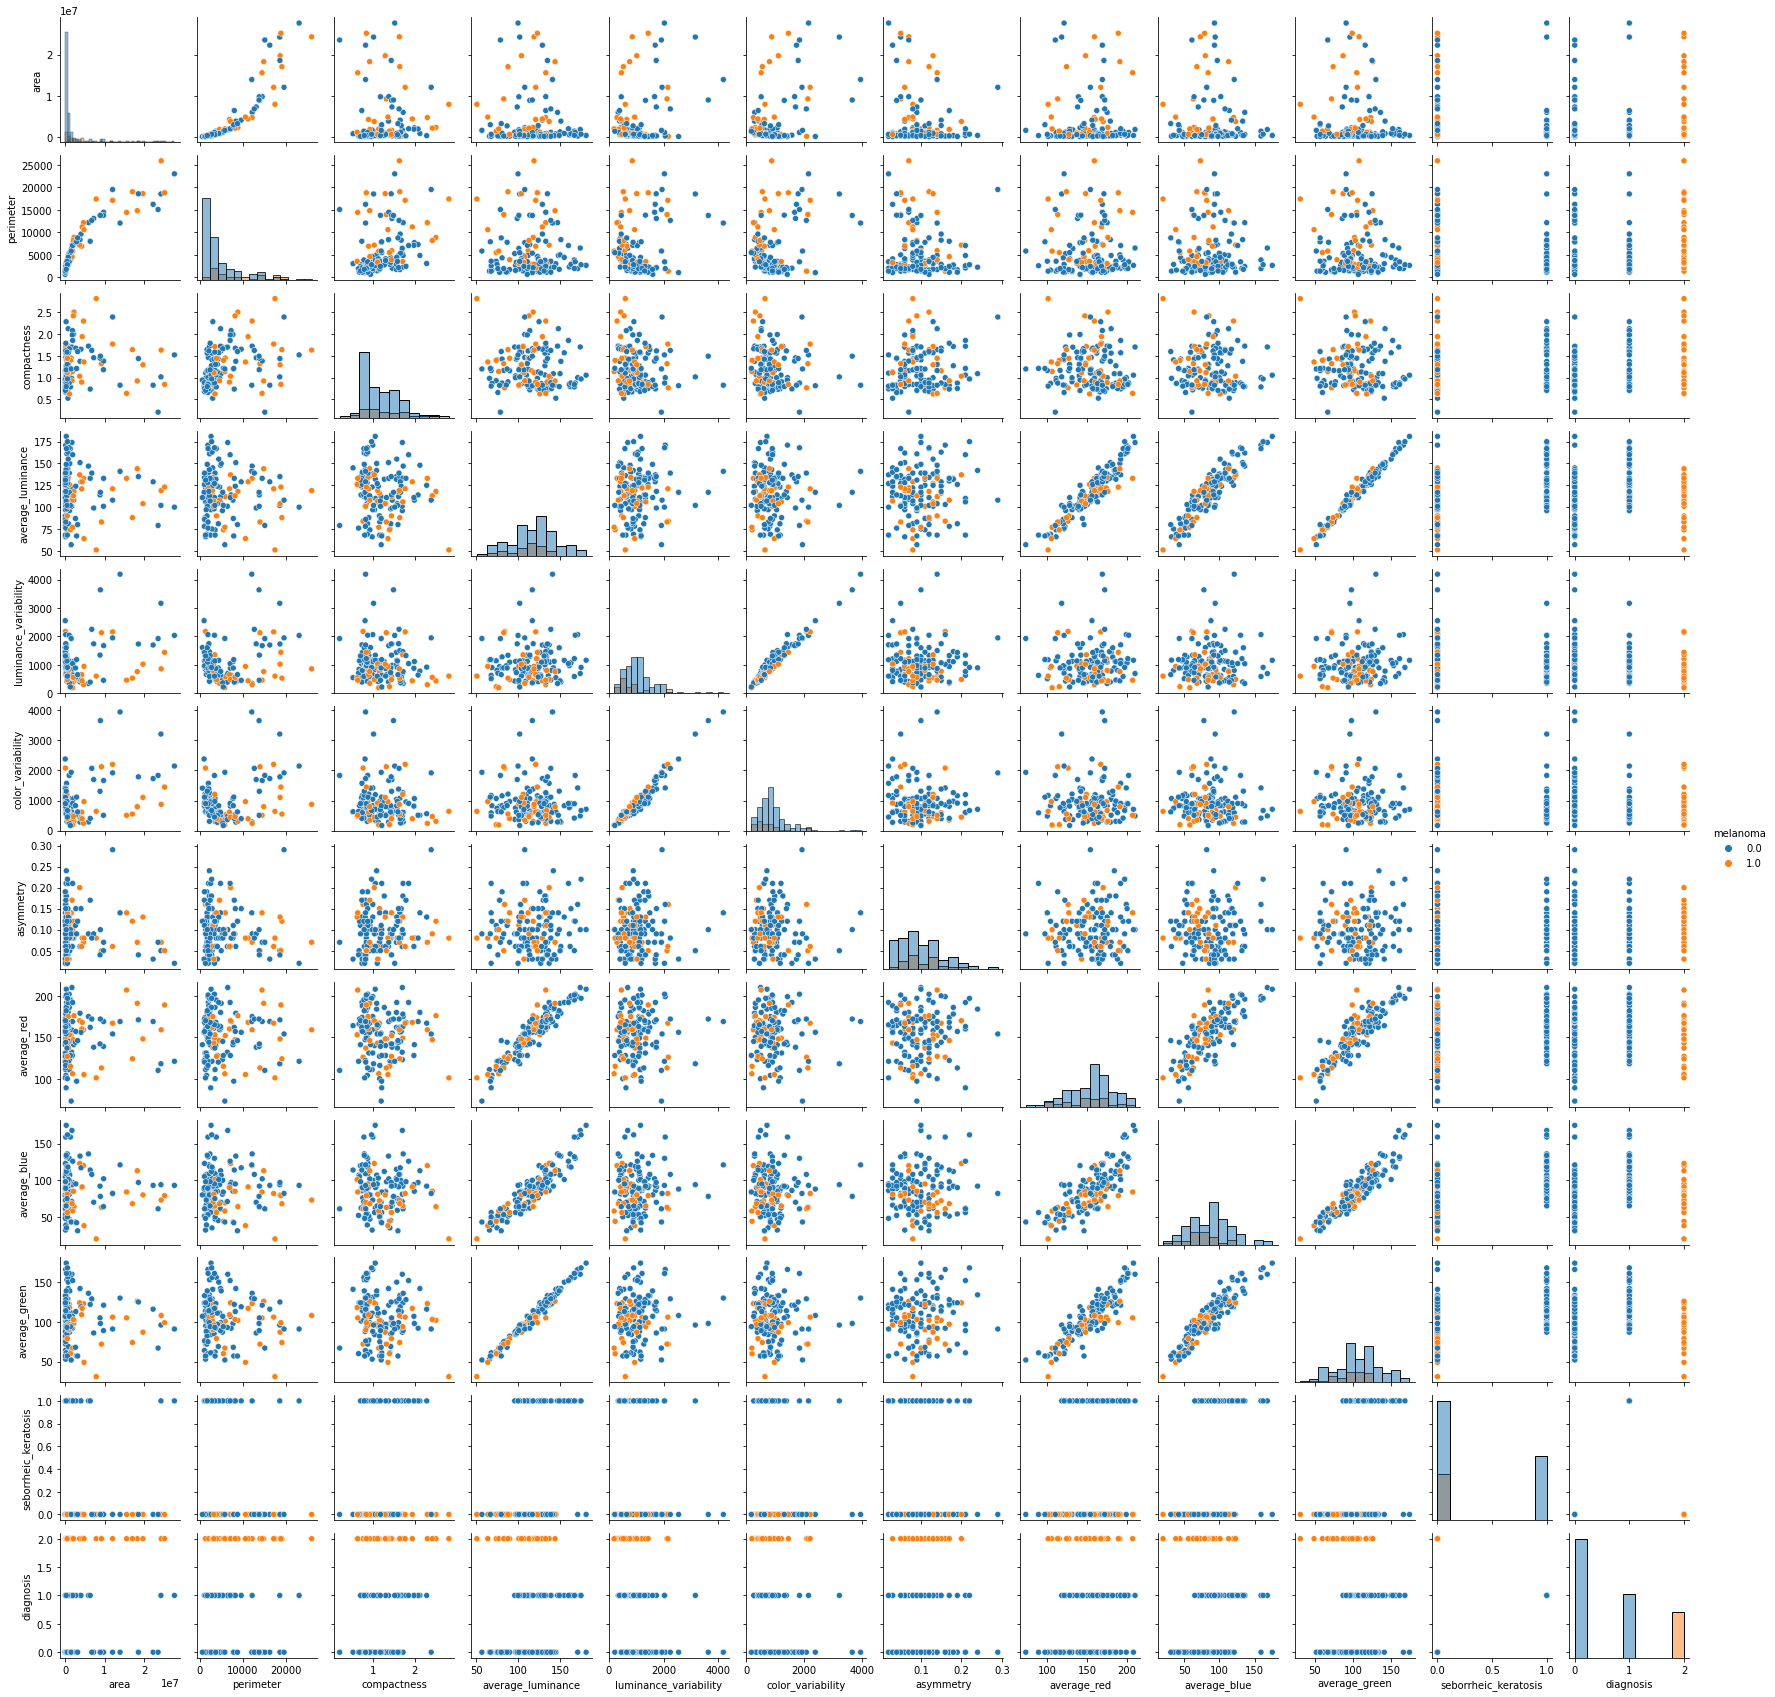

In [ ]:
sns.pairplot(DATA['features'], hue='melanoma', height=2, diag_kind="hist"); 

In [ ]:
### Selecting K-Best Features for Model



In [ ]:
a = np.array([[1,2], [3, 4]])
b = np.array([[5,6],[7, 8]])
c = np.array([[1],[2]])
print(a)
print(b)
print(c)
print(np.hstack((a,c)))

[[1 2]
 [3 4]]
[[5 6]
 [7 8]]
[[1]
 [2]]
[[1 2 1]
 [3 4 2]]


In [ ]:
# lecture code
# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((df2[['area', 'perimeter']], noise))
y = df2['melanoma']

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)

None


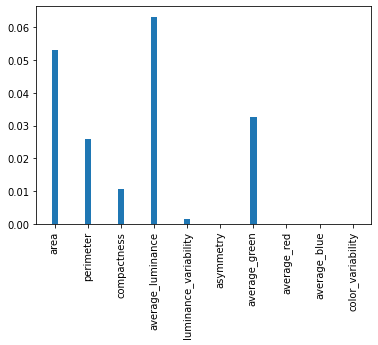

In [ ]:
# generate some noise
noise_cols = 0
noise = np.random.RandomState(100).uniform(0,0.1, size=(noise_cols, DATA['scaled_features'].shape[0])).transpose()

# Some noisy data not correlated
X = np.hstack((DATA['scaled_features'][features], noise))

y = DATA['scaled_features']['melanoma']

#X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev)


#dont need below if sequential selector works
# select k-best
selector = SelectKBest(mutual_info_classif, k=1)
selector.fit(X, y)

scores = selector.scores_
pvalues = selector.pvalues_
print(pvalues)###why is this none?
#print(scores)
# plot scores
fig, ax = plt.subplots()
ax.bar(np.arange(0,len(scores)), scores, width=.2,label=r'Feature score')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.set_xticks(np.arange(0, len(features) + noise_cols));
ax.set_xticklabels(features + ['Noise' for _ in range(noise_cols)]);

In [ ]:

#selecting best columns test
#selector_test = SelectKBest(mutual_info_classif, k=14)
#print(selector_test.fit_transform(X, y))
##these done change?? even though above values seem to

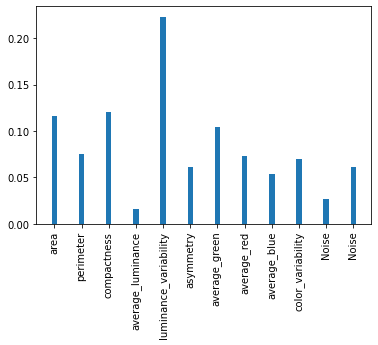

In [ ]:


# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import ExtraTreeClassifier
# load the iris datasets
# fit an Extra Tree model to the data
model = ExtraTreeClassifier()
model.fit(X, y)
model.decision_path(X)
# display the relative importance of each attribute
scores=model.feature_importances_
fig, ax = plt.subplots()
ax.bar(np.arange(0,len(scores)), scores, width=.2,label=r'Feature score')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.set_xticks(np.arange(0, len(features) + noise_cols));
ax.set_xticklabels(features + ['Noise' for _ in range(noise_cols)]);


In [ ]:
best_features_human=[[]]
best_features_mask=[[]]
has_run=False
numberchosen=1

In [ ]:
##sequential (forward) feature selection seems to work, need to test can also test backwards
from sklearn.feature_selection import SequentialFeatureSelector
if has_run==False:
    for i in range (9):
        numberchosen=int(i+1)
        print(numberchosen)
        forward_selection = SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=5), n_features_to_select=numberchosen)
        forward_selection.fit(X, y)
        chosen=forward_selection.get_support()
        best_features_human.append(list(features[chosen]))
        best_features_mask.append(list(chosen))
    has_run=True



In [ ]:
numberchosen=
print(f"The best {numberchosen} features as chosen by forward sequential feature selection are:")
print(best_features_human[numberchosen])
print(best_features_mask[numberchosen])

The best 5 features as chosen by forward sequential feature selection are:
['average_luminance', 'luminance_variability', 'asymmetry', 'average_green', 'average_blue']
[False, False, False, True, True, True, True, False, True, False]


*TASK 2*
# Predict Diagnosis

---

[Comparison of Classifiers on SciKit Learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

1. decide on _features_ and _target_ # features at random,but should decide for k best
#use feature selector or do randomly
2. normalise features 
3. _split into test, train and do cross validation (split into 5 sets)_
4. _evaluate_
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [ ]:
#code  from lecture
# Prepare cross-validation
n_splits=5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val = np.empty([n_splits,1])
acc_test = np.empty([n_splits,1])

index_fold = 0

#Parameter for nearest neighbor classifier
k = 5

# Predict labels for each fold using the KNN algortihm
for train_index, test_val_index in kf.split(x, y):
    
    
    # split dataset into a train, validation and test dataset
    test_index, val_index = np.split(test_val_index, 2)
    
    x_train, x_val, x_test = x[train_index], x[val_index], x[test_index]
    y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]
    
    # Train and test custom-made kNN classifier. In sklearn you would do this with three steps, fit(x_train, y_train), predict(x_val), predict(x_test)
    y_pred_val, y_pred_test = util.knn_classifier(x_train, y_train, x_val, x_test, k)
    
    # Calculate accuracy
    acc_val[index_fold] = accuracy_score(y_val,y_pred_val)
    acc_test[index_fold] = accuracy_score(y_test,y_pred_test)
   
    index_fold += 1
    
print(acc_val)
print(acc_test)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit #for cross-validation
from sklearn.metrics import accuracy_score

In [ ]:
def knn_classification(features, target=['melanoma'], k=5, scale=True):
    # define predictive and target labels
    X = np.array(DATA['features'][features])
    y = np.array(DATA['features'][target])

    if scale:
    # normalise features
        scaler = StandardScaler().fit(X) # (x - mu) / std 
        X = scaler.transform(X)

    # split into train and test
    #first split into training and test (0.8/0.2)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # prepare cross-validation 5 splits (on 80% of data)
    kf = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

    acc = []

    for train_index, valid_index in kf.split(X_train, Y_train):
        #find the x,y train val using indices found using kf.split
        print(train_index)
        x_train, x_valid = X_train[train_index], X_train[valid_index]
        y_train, y_valid = Y_train[train_index], Y_train[valid_index]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, np.ravel(y_train))

        acc.append(knn.score(x_valid, y_valid))
    
    print(target)
    print(acc)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(Y_train))
    print(knn.score(X_test, Y_test))


    # build cross-validation sets
    # first split into training and test (0.8/0.2)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    

    # split into training, validation and test
    #X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

    # fit model
    #knn = KNeighborsClassifier(n_neighbors=k)
    #knn.fit(X_train, y_train)

    #return knn.score(X_test,y_test)

## Model Selection for KNN

Assume we know, the features and labels we want to predict and choose a model to do, let's find the model that performs best (through robust cross-validated test-accuracy and grid searching all possible parameters)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
def build_knn(features, target=['melanoma'], scale=True):
    # define predictive and target labels
    X = np.array(DATA['features'][features]) # feature matrix
    y = np.ravel(DATA['features'][target]) # target column

    # split into train-test data (hold-out data to mimic true 'out-of-sample' data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    if scale:
    # normalise features
        scaler = StandardScaler().fit(X) # (x - mu) / std 
        X = scaler.transform(X)
    
    knn = KNeighborsClassifier()
    param_dict = {'n_neighbors': range(1,20)}
    grid = GridSearchCV(knn, param_dict, cv=10, scoring='roc_auc')
    grid.fit(X_train, y_train)
    print(grid.best_estimator_)
    print(grid.best_params_)
    print(grid.best_score_)

    # build best_k model and fit entire training data
    best_k = grid.best_params_['n_neighbors']
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train, y_train)

    # predict test data
    predicted = best_knn.predict(X_test)
    print(predicted)
    confusion = confusion_matrix(y_test, predicted)
    tp = confusion[1][1] 
    tn = confusion[0][0] 
    fp = confusion[0][1] 
    fn = confusion[1][0] 

    # accuracy
    accuracy = (tp + tn) / len(predicted) # equivalent to sklearn.metrics.accuracy_score() 

    # error 
    error = (fp + fn) / len(predicted) # 

    # sensitivity (also: true-positive-rate or recall)
    # how many of the positives did our model detect correctly?
    sensitivity = tp / (tp + fn)

    # specificity (also: )
    # how many of the negatives did our model detect correctly?
    specificity = tn / (tn + fp)

    print(accuracy)
    print(error)
    print(sensitivity)
    print(specificity)

    #scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    #specificity = cross_val_score(_model, X_train, y_train, cv=10, scoring='')
    #sensitivity = cross_val_score(_model, X_train, y_train, cv=10, scoring='')

In [ ]:
build_knn(features=features, target=['melanoma'])
# okay, our model is robust and good

#knn1.predict([239849]) => 1, 0

# so we can train all our train and give final score on test
#knn.train(x_train, y_train)
#knn.predict(x_test, y_test)

KNeighborsClassifier(n_neighbors=14)
{'n_neighbors': 14}
0.73125
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.6888888888888889
0.3111111111111111
0.0
1.0


In [ ]:
# for target in ['melanoma', 'seborrheic_keratosis', 'diagnosis']:
knn_classification(features=['area', 'perimeter'], target=['melanoma'])

[ 63 106  31 116  65  89  33  49  99  17  35  43  97  92  56  28  94   9
  60  55 102  82  75  88  83  76  51 108  61  69  78  68 119   2  74  46
  16  24  11  36   4 113 103   8 114  32  59  37 112  15  62 100 117  26
   0  73  52 111  91  70   3  58  39  53   5 101  29  13  50 107  47  77
  87  41  79  98  42  25  48  64  86 105  67 109  19 115  66  23  54  38
  21  40 110  71  45  95]
[  1 104  13  62  15  67  64  91  90  41  43  58   9   2  44  49 107  17
  20  76  25  78  85 113   5  59   7  50  18 117  73  51 106  63  39  98
  23   4  80  31  11  10  81  40   8 108  61  84   3  57  71   6  16  65
  55  22  66  70 102  29  97  28  95  32 103  54  99  60  94 101   0  52
  12  33  82  93  89 114  53  47  69  96 118  27  38  24  56  21 105  30
  35  75 115 111  79  14]
[104  26  15  27  46  71  99  70  73  51  87 113  97  60  65  79  31  93
  50  76  95 105   2  80  18  54  23  75  77  83  36   0  25  56  81  39
  28   5  21  52  58  68  63  22  86  64  12  35  69  20  90  30  13  61

In [ ]:
features=['area', 'perimeter', 'compactness', 'average_luminance', 'luminance_variability', 'asymmetry', 'average_green', 'average_red', 'average_blue', 'color_variability']

In [ ]:
#finding best kkn usng tree
X_train, X_test, y_train, y_test = train_test_split(DATA['scaled_features'][features], DATA['scaled_features']["melanoma"] , test_size=0.3, random_state=42)

from sklearn.tree import DecisionTreeClassifier
tree1 = DecisionTreeClassifier()
tree1trained = tree1.fit(X_train, y_train)

tree1trained.score(X_test, y_test)

0.6444444444444445

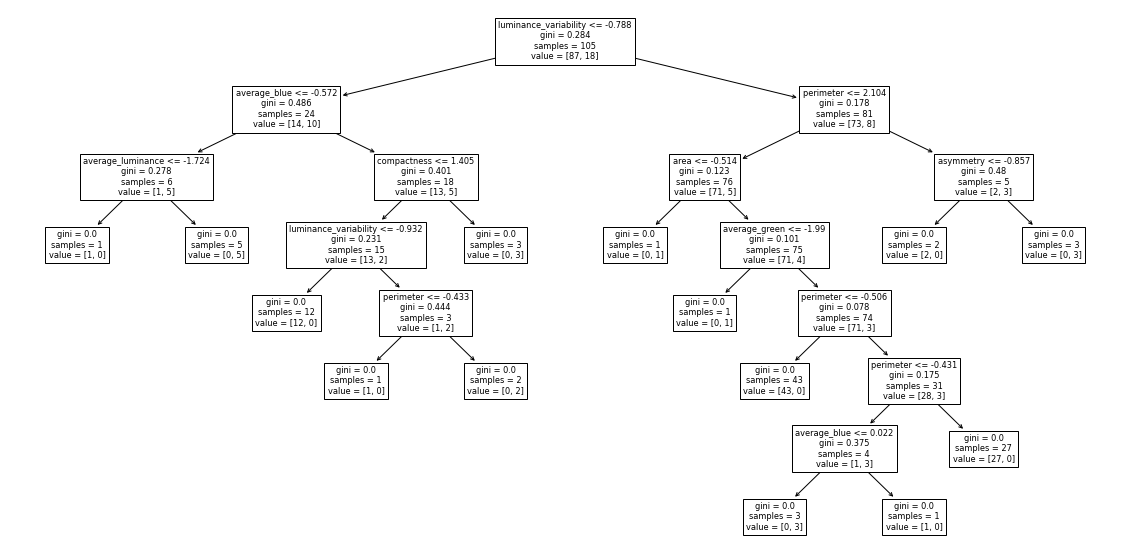

In [ ]:
from sklearn import tree
fig,ax = plt.subplots(figsize=(20,10))
ax=tree.plot_tree(tree1trained,feature_names=features);

*TASK 3*
# Open Question: ...

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5a81e04-857d-4bae-844e-8fb924df483a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>